## Healthcare Dataset Stroke Data

According to the World Health Organization, ischaemic heart disease and stroke are the world’s biggest killers. 
The goal of this project is to predict the stroke probability using the given information of patients. 
It is a binary classification problem, hence we will try to predict the probability of an observation.

In [47]:
# importing packages

from pyspark.sql import SparkSession
import pyspark.sql as sparksql
from pyspark.sql.functions import mean
from pyspark.ml.feature import VectorAssembler,OneHotEncoder,StringIndexer,OneHotEncoderEstimator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors, VectorUDT

import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('stroke').getOrCreate() #starting Spark session
train = spark.read.csv('train_2v.csv', inferSchema=True,header=True) # reading data

In [3]:
train.printSchema() # displaying schema

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [4]:
train.groupBy('stroke').count().show() # displaying number of entries under each category of predictor variable 'stroke'

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



#### Observation

From the table above, we can see that this is an imbalanced dataset, where the number of observations belonging to one class is significantly lower than those belonging to the other classes. In this case, the predictive model could be biased and inaccurate.


In [5]:
# create DataFrame as a temporary view
train.createOrReplaceTempView('table')

In [6]:
# checking what type of job is more likely to have stroke patients
spark.sql("SELECT work_type, count(work_type) as work_type_count FROM table WHERE stroke == 1 \
          GROUP BY work_type ORDER BY work_type_count DESC").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+



In [7]:
# checking number and percentage of entries of each gender
spark.sql("SELECT gender, count(gender) as count_gender, \
           count(gender)*100/sum(count(gender)) over() as percent FROM table GROUP BY gender").show()

+------+------------+-------------------+
|gender|count_gender|            percent|
+------+------------+-------------------+
|Female|       25665|  59.13594470046083|
| Other|          11|0.02534562211981567|
|  Male|       17724|  40.83870967741935|
+------+------------+-------------------+



In [8]:
# checking number and percentage of males having strokes
spark.sql("SELECT gender, count(gender), \
         (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table WHERE gender == 'Male') \
          as percentage FROM table WHERE stroke = '1' and gender = 'Male' GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|  Male|          352|1.98600767321146|
+------+-------------+----------------+



In [9]:
# checking number and percentage of females having strokes
spark.sql("SELECT gender, count(gender), \
         (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table WHERE gender == 'Female') \
          as percentage FROM table WHERE stroke = '1' and gender = 'Female' GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|Female|          431|1.67932982661212|
+------+-------------+----------------+



In [10]:
# checking if age has a relation to the number of stroke patients
spark.sql("SELECT age, count(age) as age_count FROM table WHERE stroke == 1 \
           GROUP BY age ORDER BY age_count DESC").show()

+----+---------+
| age|age_count|
+----+---------+
|79.0|       70|
|78.0|       57|
|80.0|       49|
|81.0|       43|
|82.0|       36|
|70.0|       25|
|74.0|       24|
|77.0|       24|
|76.0|       24|
|67.0|       23|
|75.0|       23|
|72.0|       21|
|68.0|       20|
|59.0|       20|
|69.0|       20|
|71.0|       19|
|57.0|       19|
|63.0|       18|
|65.0|       18|
|66.0|       17|
+----+---------+
only showing top 20 rows



In [11]:
# checking how many patients over the age of 50 have strokes
train.filter((train['stroke'] == 1) & (train['age'] > '50')).count()

708

In [12]:
# fill in missing values for smoking_status as 'No Info'
train_f = train.na.fill('No Info', subset=['smoking_status']) 

# fill in miss values for BMI with mean of all bmi values
mean = train_f.select(mean(train_f['bmi'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['bmi'])

Most of ML algorithms cannot work directly with categorical data. The encoding allows algorithms which expect continuous features to use categorical features. We convert them into vectors using the following steps:

Categorical -> StringIndexer -> OneHotEncoder -> VectorAssembler

In [13]:
gender_indexer = StringIndexer(inputCol = 'gender', outputCol = 'genderIndex')
gender_encoder = OneHotEncoder(inputCol = 'genderIndex', outputCol = 'genderVec')

In [14]:
ever_married_indexer = StringIndexer(inputCol = 'ever_married', outputCol = 'ever_marriedIndex')
ever_married_encoder = OneHotEncoder(inputCol = 'ever_marriedIndex', outputCol = 'ever_marriedVec')

In [15]:
work_type_indexer = StringIndexer(inputCol = 'work_type', outputCol = 'work_typeIndex')
work_type_encoder = OneHotEncoder(inputCol = 'work_typeIndex', outputCol = 'work_typeVec')

In [16]:
Residence_type_indexer = StringIndexer(inputCol = 'Residence_type', outputCol = 'Residence_typeIndex')
Residence_type_encoder = OneHotEncoder(inputCol = 'Residence_typeIndex', outputCol = 'Residence_typeVec')

In [17]:
smoking_status_indexer = StringIndexer(inputCol = 'smoking_status', outputCol = 'smoking_statusIndex')
smoking_status_encoder = OneHotEncoder(inputCol = 'smoking_statusIndex', outputCol = 'smoking_statusVec')

In [18]:
hypertension_indexer = StringIndexer(inputCol = 'hypertension', outputCol = 'hypertensionIndex')
hypertension_encoder = OneHotEncoder(inputCol = 'hypertensionIndex', outputCol = 'hypertensionVec')

In [19]:
heart_disease_indexer = StringIndexer(inputCol = 'heart_disease', outputCol = 'heart_diseaseIndex')
heart_disease_encoder = OneHotEncoder(inputCol = 'heart_diseaseIndex', outputCol = 'heart_diseaseVec')

Creating an assembler using VectorAssembler to combine columns into a single vector column to train ML model

### Machine Learning Models

#### Decision Tree

In [20]:
assembler = VectorAssembler(inputCols=['genderVec',
                                       'age',
                                       'hypertensionVec',
                                       'heart_diseaseVec',
                                       'ever_marriedVec',
                                       'work_typeVec',
                                       'Residence_typeVec',
                                       'avg_glucose_level',
                                       'bmi',
                                       'smoking_statusVec'],outputCol='features')

In [21]:
dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

##### Pipeline
To wrap Spark ML stages required to train the data, we need to design pipeline as shown below

In [22]:
pipeline_dtc = Pipeline(stages=[gender_indexer, ever_married_indexer, work_type_indexer, Residence_type_indexer,
                        smoking_status_indexer, hypertension_indexer, heart_disease_indexer, gender_encoder, 
                        ever_married_encoder, work_type_encoder,Residence_type_encoder, smoking_status_encoder, 
                        hypertension_encoder, heart_disease_encoder, assembler, dtc])

In [23]:
train_data,test_data = train_f.randomSplit([0.7,0.3])

In [24]:
model_dtc = pipeline_dtc.fit(train_data)
dtc_predictions = model_dtc.transform(test_data)

In [35]:
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

Decision Tree algorithm had an accuracy of: 98.10%


#### Logistic Regression

In [26]:
categoricalColumns = ['gender', 'ever_married', 'Residence_type', 'smoking_status']
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [27]:
label_stringIdx = StringIndexer(inputCol='stroke', outputCol='label')
stages += [label_stringIdx]

In [28]:
numericCols = ['age', 'avg_glucose_level', 'bmi']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [29]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(train_f)
preppedDataDF = pipelineModel.transform(train_f)

In [30]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)

In [31]:
selectedcols = ["label", "features"] + train_f.columns
dataset = preppedDataDF.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, id: int, gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: int]

In [32]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [33]:
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [34]:
acc_evaluator_lr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
lr_accuracy = acc_evaluator_lr.evaluate(predictions)
print('Logistic Regression algorithm had an accuracy of: {0:2.2f}%'.format(lr_accuracy*100))

Logistic Regression algorithm had an accuracy of: 84.19%


In [36]:
type(lr_accuracy)

float

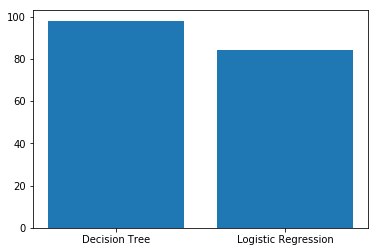

In [48]:
accuracy = [dtc_acc*100,lr_accuracy*100]
models = ('Decision Tree', 'Logistic Regression')
y_pos = np.arange(len(models))
 
# Create bars
plt.bar(y_pos, accuracy)
 
# Create names on the x-axis
plt.xticks(y_pos, models)
 
# Show graphic
plt.show()

#### Conclusion

The Decision Tree model has an accuracy of 98 percent. But this is a skewed result. As defined earlier, the predictive model of an imbalanced dataset could provide results with misleading accuracy. 

#### Remediation

* Resampling: The main objective of resampling is to either increasing the frequency of the minority class or decreasing the frequency of the majority class. This is done in order to obtain approximately the same number of instances for both the classes.

* Ensemble Methods: Ensemble methods improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their predictions.